In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import pennylane as qml
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import sys
sys.path.append("../")
from src.utils import plot_dataset, plot_predicted_result, plot_decisionon_boundaries, plot_metrics
from src.feature_map import xx_feature_map, zz_feature_map, angle_feature_map
from src.kernel import compute_kernel, kernel, evaluate_kernel
from src.schema import KernelParams, Dataset

In [2]:
RANDOM_STATE = 42
DATASET_SIZE = 1000
SAVE_IMG_DIRC = "../data/images/mnist/angle_feature_map"

feature_map_list = [xx_feature_map, zz_feature_map, angle_feature_map]
FEATURE_MAP = feature_map_list[2]

# Seeting of Quantum Device
n_qubits = 10
dev = qml.device("default.qubit", wires=n_qubits)

### 1. Load MNIST Dataset

In [3]:
digits_dataset = datasets.fetch_openml("mnist_784")
print(f"Dataset Shape: {digits_dataset.data.shape}")
print(f"Unique Label Number: {len(np.unique(digits_dataset.target))}")

Dataset Shape: (70000, 784)
Unique Label Number: 10


In [4]:
X = digits_dataset.data.to_numpy()
y = digits_dataset.target.to_numpy()

# Selecting only two classes
TARGET_CLASSES = ["0", "1"]
indices = np.where(np.isin(y, TARGET_CLASSES))[0]
X_sub = X[indices][:DATASET_SIZE]
y_sub = y[indices][:DATASET_SIZE]
y_sub = np.array([-1 if label == TARGET_CLASSES[1] else 1 for label in y_sub])

# Splitting dataset
x_train, x_test, y_train, y_test = train_test_split(
    X_sub, y_sub, test_size=0.25, random_state=RANDOM_STATE
)
print(f"Trian Shape: {x_train.shape}")
print(f"Test Shape: {x_test.shape}")

# scaling dataset
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(f"Scaled Train Shape: {x_train_scaled.shape}")
print(f"Scaled Test Shape: {x_test_scaled.shape}")

# PCA
pca = PCA(n_components=n_qubits)
pca.fit(x_train_scaled)
X_train_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(x_test_scaled)

print(f"PCA train shape: {X_train_pca.shape}")
print(f"PCA test shape: {X_test_pca.shape}")

Trian Shape: (750, 784)
Test Shape: (250, 784)
Scaled Train Shape: (750, 784)
Scaled Test Shape: (250, 784)
PCA train shape: (750, 10)
PCA test shape: (250, 10)


In [5]:
dataset = Dataset(
    x_train=X_train_pca,
    x_test=X_test_pca,
    y_train=y_train,
    y_test=y_test,
    feature_cols=[f"pca_{i+1}" for i in range(n_qubits)],
    target_col="target")

### 2. Compute Kernel Matrix

In [6]:
@qml.qnode(dev)
def kernel_with_qnode(x1, x2, kernel_params):
    return kernel(x1, x2, kernel_params)

In [7]:
kernel_params = KernelParams(
    n_qubits=n_qubits,
    feature_map=FEATURE_MAP,
    reps=1,
    kernel=kernel_with_qnode,
    # rotaion_axis=None
    rotaion_axis="X"
)

In [8]:
train_kernel = compute_kernel(dataset.x_train, dataset.x_train, kernel_params)
test_kernel = compute_kernel(dataset.x_test, dataset.x_train, kernel_params)

print(f"Train Kernel Matrix Shape: {train_kernel.shape}")
print(f"Test Kernel Matrix Shape: {test_kernel.shape}")

print(qml.draw(kernel)(dataset.x_train[0], dataset.x_train[1], kernel_params))

100%|██████████| 250/250 [04:05<00:00,  1.02it/s]

Train Kernel Matrix Shape: (750, 750)
Test Kernel Matrix Shape: (250, 750)
0: ─╭AngleEmbedding(M0)─╭AngleEmbedding(M1)†─┤ ╭Probs
1: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
2: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
3: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
4: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
5: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
6: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
7: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
8: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
9: ─╰AngleEmbedding(M0)─╰AngleEmbedding(M1)†─┤ ╰Probs
M0 = 
[10.4210898   1.20276592  7.29627372  2.04360984  1.74666643  3.9251365
  0.58506232 -0.51248459  1.03939788 -0.11752982]
M1 = 
[ 7.64257948 -2.46674894 -9.8947004  -0.56776945  1.39937292  1.19623049
 -0.37760056  0.52267758 -3.7507255  -1.71416517]


### 3. Train and Predict QSVM

In [33]:
model = SVC(kernel="precomputed")
model.fit(train_kernel, dataset.y_train)

start_time = time.time()
y_pred = model.predict(test_kernel)
end_time = time.time()
pred_time = (end_time - start_time) / test_kernel.shape[0]
print(f"Prediction time: {pred_time:.2f} [s/instance]")

accuracy = accuracy_score(dataset.y_test, y_pred)
report = classification_report(dataset.y_test, y_pred)
conf_matrix = confusion_matrix(dataset.y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Prediction time: 0.00 [s/instance]
Accuracy: 0.852

Classification Report:
               precision    recall  f1-score   support

          -1       0.84      0.88      0.86       130
           1       0.87      0.82      0.84       120

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250


Confusion Matrix:
 [[115  15]
 [ 22  98]]


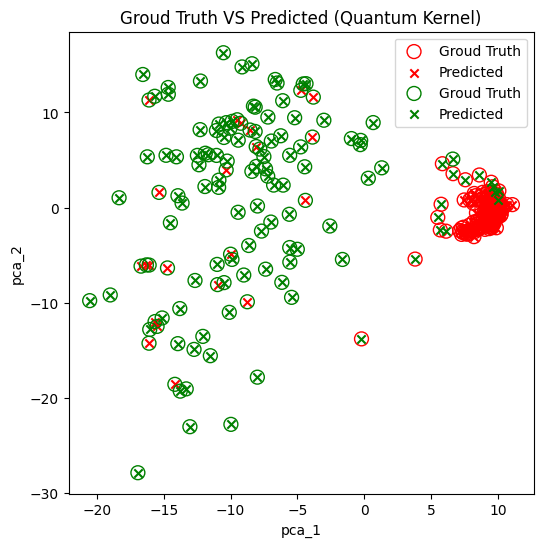

In [34]:
plot_predicted_result(
    dataset, 
    y_pred,
    save_path=None
    # save_path=f"{SAVE_IMG_DIRC}/reps{kernel_params.reps}_predict.png"
    )

Calculating Kernel Matrix for 450 mesh points


100%|██████████| 450/450 [03:13<00:00,  2.32it/s]


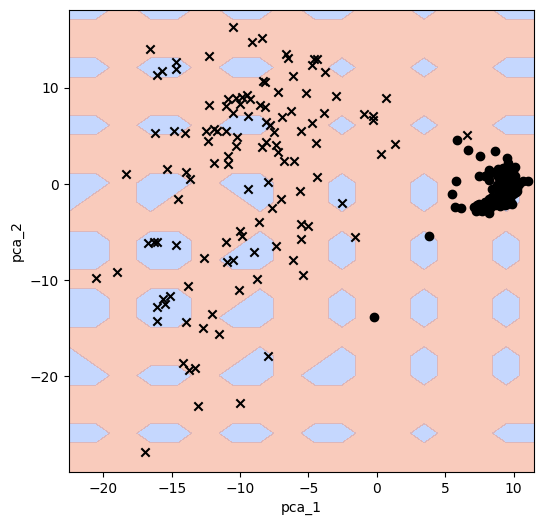

In [35]:
plot_decisionon_boundaries(
    model, 
    dataset,
    kernel_params,
    step_size=2.0, 
    save_path=None
    # save_path=f"{SAVE_IMG_DIRC}/reps{kernel_params.reps}_boundary.png"
)

In [36]:
_, _ = evaluate_kernel(dataset.x_train, dataset.y_train, kernel_params)

Target Kernel Alignment: 0.12
Kernel Polarity: 0.07


### Base Line

In [7]:
classic_model = SVC(kernel='rbf', random_state=RANDOM_STATE)
classic_model.fit(dataset.x_train, dataset.y_train)

y_pred = classic_model.predict(dataset.x_test)
accuracy = accuracy_score(dataset.y_test, y_pred)
report = classification_report(dataset.y_test, y_pred)
conf_matrix = confusion_matrix(dataset.y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.996

Classification Report:
               precision    recall  f1-score   support

          -1       0.99      1.00      1.00       130
           1       1.00      0.99      1.00       120

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250


Confusion Matrix:
 [[130   0]
 [  1 119]]


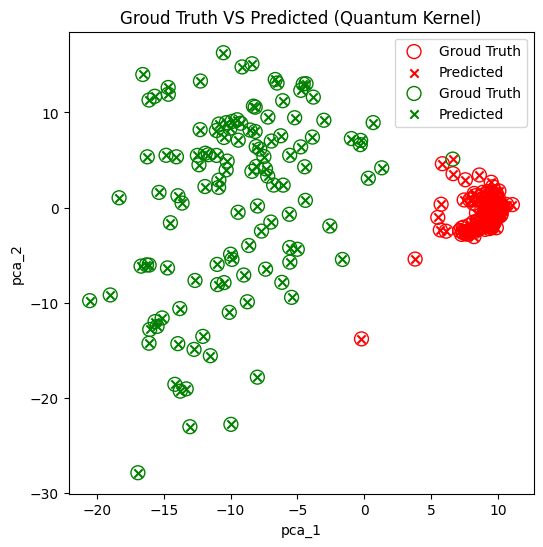

In [8]:
plot_predicted_result(
    dataset, 
    y_pred,
    save_path=None
    # save_path=f"{SAVE_IMG_DIRC}/reps{kernel_params.reps}_predict.png"
    )